In [4]:
import numpy as np
import math
from typing import *
from collections import deque
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
MAF21 = pd.read_csv('azurefunctions-accesses-2020-first-hour.csv')

sns.set(rc={"font.size":13,"axes.labelsize":13,"xtick.labelsize":13,"ytick.labelsize":13,"savefig.dpi":200,"figure.figsize":(7, 2.5 ),"lines.linewidth": 2})
sns.set_style("white")


In [5]:
def generate_gamma_distribution_using_MAF21(tasks):
    """
    Generate a gamma distribution using the MAF21 workload.
    """
    df_first_hour = MAF21.copy()
    tasks_distribution = {}
    query_counts = df_first_hour['AnonAppName'].value_counts()
    qps = query_counts / 3600 
    qps_df = pd.DataFrame({'AnonAppName': qps.index, 'AnonAppName_qps': qps.values})
    df_first_hour = pd.merge(df_first_hour, qps_df, on='AnonAppName', how='left')
    min_timestamp = df_first_hour['Timestamp'].min()
    df_first_hour['AdjustedTimestamp'] = df_first_hour['Timestamp'] - min_timestamp
    df_first_hour['AdjustedTimestamp'] = df_first_hour['AdjustedTimestamp']/1000
    # Use KMeans to cluster
    kmeans = KMeans(n_clusters=tasks, random_state=0)
    df_first_hour['Cluster'] = kmeans.fit_predict(df_first_hour[['AnonAppName_qps']])
    for i in range(tasks):
        cluster_data = df_first_hour[df_first_hour['Cluster'] == i]
        # cluster_data[['AdjustedTimestamp']].to_csv(f'MAF21/cluster_{i}.txt', index=False, header=True)
        tasks_distribution[i] = cluster_data[['AdjustedTimestamp']].values.flatten()
    return tasks_distribution


# generate_gamma_distribution_using_MAF21(10)


In [6]:
# fair share scheduling, each subgraph has an exclusive GPU
def exclusive_testbed(total_time: float, gpus: int, tasks: int, infer_time: float, pass_time: float, stages: int = 4, timeout: float = 10):

  tasks_distribution = generate_gamma_distribution_using_MAF21(tasks)

  least_replicas = gpus // (tasks * stages)
  if least_replicas == 0:
    raise ValueError("Not enough GPUs to schedule all the tasks")
  replicas = [least_replicas] * tasks
  used_gpus = least_replicas * tasks * stages
  
  i = 0
  while used_gpus + stages <= gpus:
    replicas[i] += 1
    used_gpus += stages
    i += 1
  gpu_reqs = [[] for _ in range(gpus)]
  scheduler_idx = [0] * tasks
  gpu_idx_base = 0
  for i in range(tasks):
    dist = tasks_distribution[i]
    if i > 0:
      gpu_idx_base += replicas[i-1] * stages
    for req in dist:
      gpu_idx = scheduler_idx[i] * stages + gpu_idx_base
      start_timestamp = max(req, gpu_reqs[gpu_idx][-1][1] if len(gpu_reqs[gpu_idx]) > 0 else 0)
      if start_timestamp + stages * infer_time + (stages - 1) * pass_time - req <= timeout:
        for s in range(stages):
          end_timestamp = start_timestamp + infer_time
          gpu_reqs[gpu_idx + s].append((start_timestamp, end_timestamp))
          start_timestamp = end_timestamp + pass_time
      scheduler_idx[i] = (scheduler_idx[i] + 1) % replicas[i]
  gpu_utils = [0] * gpus
  for i in range(gpus):
    for req in gpu_reqs[i]:
      if req[1] > total_time:
        gpu_utils[i] += total_time - min(req[0], total_time)
        break
      gpu_utils[i] += req[1] - req[0]
    gpu_utils[i] /= total_time
  return gpu_utils

In [14]:
simulation_gpu_utils = pd.DataFrame(columns=['tasks', 'average_utilization'])
simulation_gpu_utils_detail = pd.DataFrame(columns=['tasks', 'utilization', 'gpu'])
for i in range(1, 64, 7):
    results = exclusive_testbed(total_time=3600, gpus=256, tasks=i, infer_time=0.279, pass_time=0.01, stages=4)
    # print(results)
    simulation_gpu_utils = pd.concat([simulation_gpu_utils, pd.DataFrame({'tasks': [i], 'average utilization': [np.mean(results)]})])
    for j in range(len(results)):
        simulation_gpu_utils_detail = pd.concat([simulation_gpu_utils_detail, pd.DataFrame({'tasks': [i], 'utilization': [results[j]], 'gpu': [j]})])
simulation_gpu_utils.to_csv('exclusive.csv', index=False, header=True)
simulation_gpu_utils_detail.to_csv('exclusive_detail.csv', index=False, header=True)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [ ]:
def exclusive_testbed_new(total_time: float, gpus: int, tasks: int, infer_time: float, pass_time: float, stages: int = 4, timeout: float = 10):
    tasks_distribution = generate_gamma_distribution_using_MAF21(tasks)

    # Assuming each task requires 'stages' number of GPUs and each GPU can only handle one stage of a task at a time.
    if gpus < tasks * stages:
        raise ValueError("Not enough GPUs to schedule all the tasks")

    # Initialize GPU requests for each GPU
    gpu_reqs = [[] for _ in range(gpus)]

    # Distribute tasks across GPUs
    for task_id in range(tasks):
        gpu_base = (task_id * stages) % gpus
        dist = tasks_distribution[task_id]
        for req in dist:
            start_timestamp = req
            for stage in range(stages):
                gpu_idx = (gpu_base + stage) % gpus
                end_timestamp = start_timestamp + infer_time
                if end_timestamp - req <= timeout:
                    gpu_reqs[gpu_idx].append((start_timestamp, end_timestamp))
                start_timestamp = end_timestamp + pass_time

    # Calculate GPU utilization
    gpu_utils = [0] * gpus
    for gpu_idx, reqs in enumerate(gpu_reqs):
        for start, end in reqs:
            adjusted_end = min(end, total_time)
            gpu_utils[gpu_idx] += max(0, adjusted_end - max(start, 0))
        gpu_utils[gpu_idx] /= total_time

    return gpu_utils


In [ ]:
for i in range(1, 64, 4):
    results = exclusive_testbed_new(total_time=600, gpus=300, tasks=i, infer_time=0.1, pass_time=0.01, stages=4)
    # print(results)
    print(sum(results) / len(results))

In [8]:
# fair share scheduling, multiple subgraphs share an GPU
def memory_sharing_testbed(
    total_time: float,
    gpus: int,
    tasks: int,
    infer_time: float,
    pass_time: float,
    num_sharing_gpu: int = 4,
    stages: int = 4,
    timeout: float = 10,
):
    tasks_distribution = generate_gamma_distribution_using_MAF21(tasks)
    least_replicas = gpus * num_sharing_gpu // (tasks * stages)
    if least_replicas == 0:
        raise ValueError("Not enough GPUs to schedule all the tasks")
    replicas = [least_replicas] * tasks
    used_gpus = least_replicas * tasks * stages

    task_reqs = [[] for _ in range(tasks)]

    i = 0
    while used_gpus + stages <= gpus * num_sharing_gpu:
        replicas[i] += 1
        used_gpus += stages
        i += 1
    gpu_reqs = [[] for _ in range(gpus)]
    scheduler_idx = [0] * tasks
    dists = []
    for i in range(tasks):
        dist = tasks_distribution[i]
        for req in dist:
            dists.append((i, req))
    dists.sort(key=lambda x: x[1])
    gpu_idx_bases = [0] * tasks
    for i in range(1, tasks):
        gpu_idx_bases[i] = gpu_idx_bases[i - 1] + replicas[i - 1] * stages
    for i, req in dists:
        gpu_idx = scheduler_idx[i] * stages + gpu_idx_bases[i]
        start_timestamp = req
        is_timeout = False
        for s in range(stages):
            idx = (gpu_idx + s) // num_sharing_gpu
            start_timestamp = max(
                start_timestamp, gpu_reqs[idx][-1][1] if len(gpu_reqs[idx]) > 0 else 0
            )
            if start_timestamp > req + timeout:
                is_timeout = True
                break
            end_timestamp = start_timestamp + infer_time
            gpu_reqs[idx].append((start_timestamp, end_timestamp))
            start_timestamp = end_timestamp + pass_time
        if is_timeout or end_timestamp > timeout + req:
            task_reqs[i].append((req, req + timeout, 500))
        else:
            task_reqs[i].append((req, end_timestamp, 200))
        scheduler_idx[i] = (scheduler_idx[i] + 1) % replicas[i]

    gpu_utils = [0] * gpus
    for i in range(gpus):
        for req in gpu_reqs[i]:
            if req[1] > total_time:
                gpu_utils[i] += total_time - min(req[0], total_time)
                break
            gpu_utils[i] += req[1] - req[0]
        gpu_utils[i] /= total_time

    latency = [0] * tasks
    slo_violations = [0] * tasks
    for i in range(tasks):
        good, violation = 0, 0
        for req in task_reqs[i]:
            if req[2] == 200:
                good += 1
                latency[i] += req[1] - req[0]
            else:
                violation += 1
        latency[i] /= good
        slo_violations[i] = violation / (good + violation)

    return gpu_utils, latency, slo_violations


# gpu_utils, latency, slo_violations = memory_sharing_testbed(
#     total_time=600,
#     gpus=512,
#     tasks=56,
#     infer_time=0.1,
#     pass_time=0.01,
#     num_sharing_gpu=8,
#     stages=4,
# )
# print("GPU utils:", gpu_utils)
# print("Latency:", latency)
# print("SLO violations:", slo_violations)

In [18]:
sharing = pd.DataFrame(columns=['tasks', 'average_utilization'])
sharing_detail = pd.DataFrame(columns=['tasks', 'utilization', 'gpu'])

for i in range(1, 64, 7):
    gpu_utils, latency, slo_violations = memory_sharing_testbed(
        total_time=3600,
        gpus=256,
        tasks=i,
        infer_time= 0.349,
        pass_time=0.01,
        num_sharing_gpu=16,
        stages=16,
        )
    # print("GPU utils:", gpu_utils)
    # print("Latency:", latency)
    # print("SLO violations:", slo_violations)
    sharing = pd.concat([sharing, pd.DataFrame({'tasks': [i], 'average utilization': [np.mean(gpu_utils)]})])
    for j in range(len(gpu_utils)):
        sharing_detail = pd.concat([sharing_detail, pd.DataFrame({'tasks': [i], 'utilization': [gpu_utils[j]], 'gpu': [j]})])
sharing.to_csv('sharing.csv', index=False, header=True)
sharing_detail.to_csv('sharing_detail.csv', index=False, header=True)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

/tmp/ipykernel_1040249/1175965985.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=sharing, x="tasks", y="average utilization", ax=ax, palette="Set1", label='sharing')
/tmp/ipykernel_1040249/1175965985.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=exclusive, x="tasks", y="average utilization", ax=ax, palette="Set1", label='exclusive')


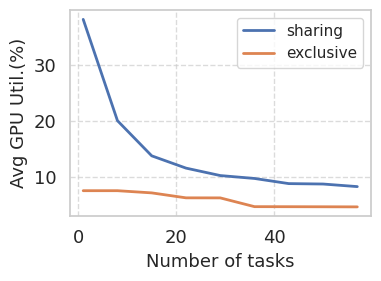

In [19]:
import numpy as np
import math
from typing import *
from collections import deque
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
MAF21 = pd.read_csv('azurefunctions-accesses-2020-first-hour.csv')

sns.set(rc={"font.size":13,"axes.labelsize":13,"xtick.labelsize":13,"ytick.labelsize":13,"savefig.dpi":200,"figure.figsize":(7, 2.5 ),"lines.linewidth": 2})
sns.set_style("white")


sns.set(rc={"font.size":13,"axes.labelsize":13,"xtick.labelsize":13,"ytick.labelsize":13,"savefig.dpi":200,"figure.figsize":(7, 2.5 ),"lines.linewidth": 2})
sns.set_style("whitegrid")
# plot exclusive and share together
fig, ax = plt.subplots(figsize=(4, 3))
# colors = ['#8CD17D','#E15759']
sharing = pd.read_csv('sharing.csv')
sharing['average utilization'] = sharing['average utilization'] * 100
sns.lineplot(data=sharing, x="tasks", y="average utilization", ax=ax, palette="Set1", label='sharing')
exclusive = pd.read_csv('exclusive.csv')
exclusive['average utilization'] = exclusive['average utilization'] * 100
sns.lineplot(data=exclusive, x="tasks", y="average utilization", ax=ax, palette="Set1", label='exclusive')
ax.set(xlabel='Number of tasks', ylabel='Avg GPU Util.(%)')
ax.legend(loc='upper right')
ax.grid(True,linestyle='--', alpha=0.7)
plt.tight_layout()
fig.savefig('exclusive_share.pdf', bbox_inches='tight',dpi=120)
